## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor

## Данные

In [2]:
df = pd.read_csv('Очищенные_данные_2.csv', sep=',', index_col=0, parse_dates=['DT'])
df.head()

,DT,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
nplv,,,,,,,,,,,,,,,,,,,,,
г6837?3<87?,2070-06-21 00:14:00,29.0,45.366667,24.400000,41.033333,NaN,0.456460,0.059572,0.117446,0.104762,...,0.12,2.6,0.0,NaN,53.4,1.0,5.8,0.15,2.6,NaN
г683863<887,2070-06-21 02:00:00,24.0,43.350000,17.950000,43.350000,NaN,0.331665,0.081490,0.132332,0.139860,...,0.12,2.6,0.0,NaN,57.2,0.5,8.1,0.13,2.3,NaN
г683863<888,2070-06-21 02:58:00,17.0,46.183333,19.816667,46.183333,NaN,0.377945,0.133194,0.221605,0.165186,...,0.11,2.4,0.0,NaN,60.3,0.5,6.3,0.12,2.6,NaN
г683863<889,2070-06-21 03:50:00,20.0,48.500000,17.033333,48.500000,NaN,0.389875,0.105094,0.169459,0.143024,...,0.12,2.4,0.0,NaN,60.3,0.6,4.5,0.09,2.5,NaN
г683863<968,2070-06-24 14:43:00,20.0,47.516667,24.966667,47.016667,3.107531,0.541855,0.143310,0.234872,0.208873,...,0.51,2.0,0.0,NaN,59.2,1.0,7.1,0.19,2.2,NaN


In [3]:
len(df.columns)

68

## Feature Engineering

In [4]:
pearson_corr = df.drop('DT', axis=1).corr(method='pearson', min_periods=50)
pos_corr = np.abs(np.nan_to_num(pearson_corr.values, 0.0))
strong_corr_pairs = []
for i in range(1, len(pos_corr)):
    if np.max(pos_corr[i, :i]) >= 0.8:
        j = np.argmax(pos_corr[i, :i])
        strong_corr_pairs.append((i, j, pearson_corr.values[i, j]))

In [5]:
cols = df.drop('DT', axis=1).columns
cols_dict = dict(list(zip(range(len(cols)), cols)))

In [6]:
# сильно коррелирующие фичи
strong_corr_df = pd.DataFrame(strong_corr_pairs).replace(cols_dict).sort_values(2, ascending=False)
strong_corr_df

,0,1,2
5,ферспл SiMn18,чист расход Mn,0.998350
6,ферспл фх850А,чист расход Cr,0.997216
14,химсталь последний Ni,химсталь первый Ni_1,0.993611
12,химсталь последний Cu,химсталь первый Cu_1,0.989659
0,t продувка,t обработка,0.988132
3,ферспл FeV-80,чист расход V,0.985564
7,эл. энергия,t под током,0.962606
15,химсталь последний P,химсталь первый P_1,0.958760
13,химсталь последний Mo,химсталь первый Mo_1,0.957203
2,сыпуч кокс. мелочь КМ1,чист расход C,0.955960


In [7]:
cols_for_engineering = ['химсталь последний Ni',
                        'химсталь последний Cu',
                        'химсталь последний P',
                        'химсталь последний Mo',
                        'химшлак первый SiO2_1']
corr_cols_to_drop = [col for col in strong_corr_df[0] if col not in cols_for_engineering]

In [8]:
df.drop(corr_cols_to_drop, axis=1, inplace=True)

In [9]:
pairs = strong_corr_df[strong_corr_df[0].isin(cols_for_engineering)][[0,1]].values
pairs

array([['химсталь последний Ni', 'химсталь первый Ni_1'],
       ['химсталь последний Cu', 'химсталь первый Cu_1'],
       ['химсталь последний P', 'химсталь первый P_1'],
       ['химсталь последний Mo', 'химсталь первый Mo_1'],
       ['химшлак первый SiO2_1', 'химшлак первый Al2O3_1']], dtype=object)

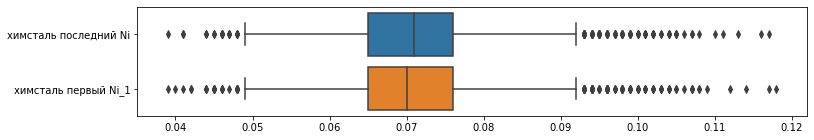

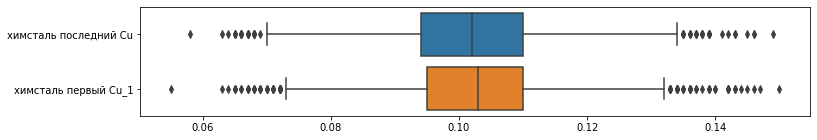

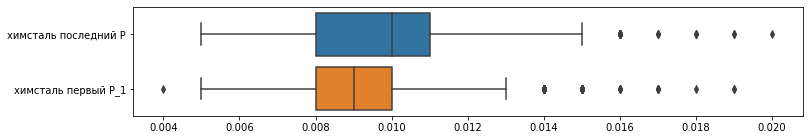

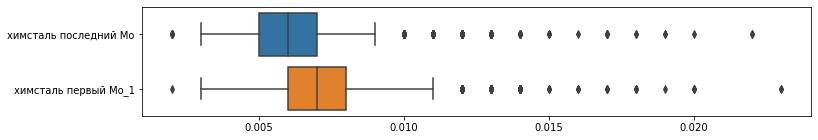

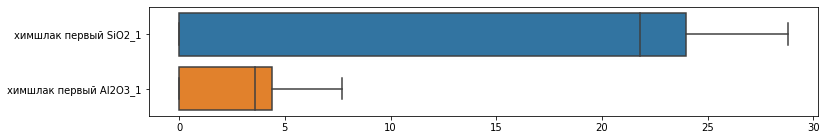

In [10]:
for pair in pairs:
    fig = plt.figure(figsize=(12, 2))
    sns.boxplot(data=df[pair], orient='h')

Колонки с Ni и Cu можно убрать.

In [11]:
df.drop(['химсталь первый Cu_1', 'химсталь первый Ni_1'], axis=1, inplace=True)

In [12]:
pairs = np.delete(pairs, 0, axis=0) # ['химсталь последний Ni', 'химсталь первый Ni_1']
pairs = np.delete(pairs, 0, axis=0) # ['химсталь последний Cu', 'химсталь первый Cu_1']

Попробуем отношение.

In [13]:
def safe_division(x, y):
    if (x != x) | (y != y) | (y == 0):
        return np.nan
    return x / y

for pair in pairs:
    new_col = pair[0]+'_'+pair[1]+'_ratio'
    df[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)

## Feature Importance

In [14]:
TARGETS = ['химшлак последний Al2O3', 'химшлак последний CaO',
           'химшлак последний R', 'химшлак последний SiO2']

In [15]:
df.drop('DT', axis=1, inplace=True) # не понадобится, скорее всего

In [16]:
for col in df.columns:
    if df[col].nunique() <= 50:
        df[col] = df[col].astype('category')

In [17]:
NUMERICAL = df.select_dtypes(exclude=['object', 'datetime64']).columns.tolist()
# ORDINAL = df.select_dtypes(include=['category']).columns.tolist()
for tar in TARGETS:
    if tar in NUMERICAL:
        NUMERICAL.remove(tar)

#### Correlations

In [18]:
correlations = dict()

for tar in TARGETS:
    correlations[tar] = dict()
    for col in NUMERICAL:
        correlations[tar][col] = df[col].corr(df[tar])

In [19]:
corrs = pd.DataFrame(correlations)
corrs[(abs(corrs) > 0.5).any(1)]

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
химшлак первый Al2O3_1,0.630918,-0.083420,0.098214,-0.202930
химшлак первый R_1,0.330314,0.343483,0.583721,-0.373604
химшлак последний MgO,-0.253654,-0.438164,-0.508423,0.275869
химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio,-0.647657,0.003345,-0.287558,0.321874


In [20]:
golden_features = list(corrs[(abs(corrs) > 0.3).any(1)].index)

#### Imputter

In [21]:
from sklearn.impute import KNNImputer

def knn_impute(df, col):
    imputer = KNNImputer(n_neighbors=2)
    imp_col = imputer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    imp_col = [item[0] for item in imp_col.tolist()]
    df[col] = imp_col

In [22]:
cols = set(df.columns) - set(TARGETS)
nan_cols=[col for col in cols if df[col].isnull().values.any()]

In [23]:
#Стратегия knn 
for col in nan_cols:
    knn_impute(df, col)

#### Lasso

In [24]:
data = df.dropna().astype(float)
data = (data - data.mean()) / (data.std() + 0.0001)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(columns = TARGETS),
    data[TARGETS],
    test_size=0.3,
    shuffle = True)

In [26]:
clf = linear_model.Lasso(alpha=0.02)
clf.fit(x_train, y_train)

Lasso(alpha=0.02)

In [27]:
names = df.drop(columns = TARGETS).columns
for i,m in enumerate(clf.coef_):
    print(TARGETS[i])
    print(names[np.where(m != 0)].values)

химшлак последний Al2O3
['t под током' 'ПСН гр.' 'чист расход C' 'чист расход Mn' 'чист расход Si'
 'температура первая' 'Ar (интенс.)' 'произв жидкая сталь'
 'химсталь первый Al_1' 'химсталь последний Al' 'химсталь последний C'
 'химсталь последний Mo' 'химсталь последний N' 'химсталь последний Ni'
 'химсталь последний V' 'химшлак первый Al2O3_1' 'химшлак первый MnO_1'
 'химшлак первый R_1' 'химшлак первый SiO2_1' 'химшлак последний FeO'
 'химшлак последний MgO' 'химшлак последний MnO'
 'химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio']
химшлак последний CaO
['t под током' 'ПСН гр.' 'чист расход C' 'чист расход Cr' 'чист расход Si'
 'чист расход V' 'температура первая' 'эл. энергия (интенс.)'
 'сыпуч известь РП' 'сыпуч  шпат плав.' 'ферспл CaC2'
 'химсталь первый S_1' 'химсталь последний C' 'химсталь последний Ca'
 'химсталь последний Cu' 'химсталь последний S' 'химсталь последний Ti'
 'химшлак первый Al2O3_1' 'химшлак первый CaO_1' 'химшлак первый MnO_1'
 'химшлак первый R_1' 'хим

#### Random Forest

In [28]:
cols = data.columns
for tar in TARGETS:
    forest = RandomForestRegressor(n_estimators=100,
                                   oob_score = True,
                                   bootstrap = True,
                                   random_state=42)
    forest.fit(data.drop(columns = TARGETS), data[tar])
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Feature ranking for {}:".format(tar))
    for f in range(data.shape[1] - len(TARGETS)):
        print("%d.\t %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
    print()

Feature ranking for химшлак последний Al2O3:
1.	 химшлак первый SiO2_1_химшлак первый Al2O3_1_ratio (0.451005)
2.	 химшлак последний MnO (0.058252)
3.	 химшлак первый Al2O3_1 (0.036700)
4.	 чист расход C (0.031011)
5.	 химшлак последний MgO (0.016609)
6.	 химшлак первый CaO_1 (0.015629)
7.	 химшлак первый MgO_1 (0.015467)
8.	 чист расход Si (0.014343)
9.	 температура первая (0.014294)
10.	 чист расход Cr (0.014117)
11.	 t вып-обр (0.013087)
12.	 температура последняя (0.012906)
13.	 чист расход Mn (0.012865)
14.	 t обработка (0.012851)
15.	 химсталь последний C (0.012287)
16.	 химшлак первый SiO2_1 (0.012167)
17.	 Ar (интенс.) (0.012159)
18.	 химсталь последний Si (0.011974)
19.	 эл. энергия (интенс.) (0.011956)
20.	 химсталь последний Cu (0.011588)
21.	 t под током (0.011570)
22.	 чист расход V (0.011466)
23.	 сыпуч  шпат плав. (0.011399)
24.	 химсталь последний S (0.011388)
25.	 химсталь последний Ni (0.010663)
26.	 сыпуч известь РП (0.010482)
27.	 произв жидкая сталь (0.010203)
28.	

In [29]:
important_features = dict.fromkeys(TARGETS, {})
for i,m in enumerate(clf.coef_):
    important_features[TARGETS[i]] = set(list(names[np.where(m != 0)].values) + golden_features)

## Model

In [30]:
df[TARGETS].count() / df.shape[0]

химшлак последний Al2O3    0.74297
химшлак последний CaO      1.00000
химшлак последний R        1.00000
химшлак последний SiO2     0.74297
dtype: float64

In [31]:
pred_idx = df[df[TARGETS].isna().any(1)].index
train_test_idx = df[~df[TARGETS].isna().any(1)].index

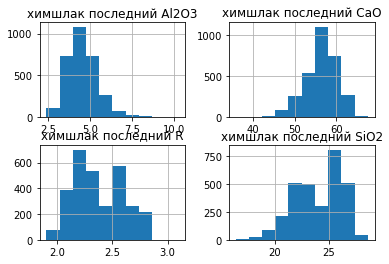

In [33]:
df.loc[train_test_idx, TARGETS].astype(float).hist();

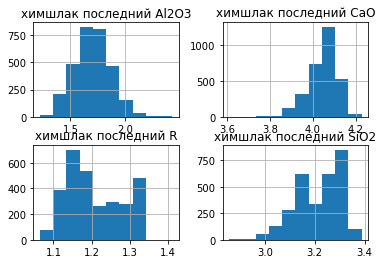

In [34]:
df.loc[train_test_idx, TARGETS].apply(lambda x: np.log(x.astype('float64')+1), axis=1).hist();

### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

In [63]:
def train_DT(df, features, target):
    X, y = df[features], df[target]
    regressor = DecisionTreeRegressor(criterion='mse', random_state = 0)
    tuned_parameters = {'max_depth': [3, 5, 10, 20, 50],
                        'min_samples_split': [2, 3, 4]}
    dt = GridSearchCV(regressor, tuned_parameters, cv=3, verbose=True, n_jobs=-1)
    dt.fit(X, y)
    best_dt = dt.best_estimator_
    return best_dt

In [64]:
TARGETS

['химшлак последний Al2O3',
 'химшлак последний CaO',
 'химшлак последний R',
 'химшлак последний SiO2']

In [67]:
target = 'химшлак последний Al2O3'
model = train_DT(df.loc[train_test_idx], df.columns, target)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.0s finished


In [68]:
cross_val_score(model, 
                df.loc[train_test_idx],
                df.loc[train_test_idx, target], 
                cv=3)

array([0.99451734, 0.99830768, 0.9998788 ])

### Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression, ElasticNet

In [36]:
target = 'химшлак последний Al2O3'

In [56]:
X, y = df.loc[train_test_idx], df.loc[train_test_idx, target]

In [57]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0, test_size=.3, shuffle=True)

In [58]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [59]:
train_X = sc.fit_transform(train_X)
val_X = sc.fit_transform(val_X)

In [60]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(train, val, tr_y, val_y, features, est):
    est.fit(train, tr_y)
    pred_val = est.predict(val)
    pred_train = est.predict(train)
    
    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    })

In [61]:
reg = LinearRegression()
scores = evaluate_model(train_X, val_X, np.log(train_y+1), np.log(val_y+1), important_features[target], reg)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.016647,0.989165,0.017995,0.987517


In [69]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
gs = GridSearchCV(
        ElasticNet(random_state=0), 
        {
            'alpha': np.linspace(0, 300, 10),
            'l1_ratio': np.arange(0, 1.1, 0.1)
        }, 
        n_jobs=-1, 
         scoring=['neg_mean_squared_error', 'r2'], 
         refit='neg_mean_squared_error',
         cv=cv, 
         verbose=10
)

In [70]:
%%time
gs.fit(train_X, train_y);

Fitting 3 folds for each of 110 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0800s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1812s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1250s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 307 tasks      | elapsed:    3.2s


Wall time: 3.72 s


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    3.6s finished
C:\Users\Luybo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\Luybo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=ElasticNet(random_state=0), n_jobs=-1,
             param_grid={'alpha': array([  0.        ,  33.33333333,  66.66666667, 100.        ,
       133.33333333, 166.66666667, 200.        , 233.33333333,
       266.66666667, 300.        ]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'], verbose=10)

In [71]:
gs.best_params_

{'alpha': 0.0, 'l1_ratio': 0.0}